#QP 2 Analysis
## Vincent Mariani
## 12-15-2025

---


In [2]:
# Loading Packages
library(tidyverse)
library(easystats)

library(arrow) # For reading .parquet files, which are much smaller

library(ggplot2)
library(ggthemes)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   4.0.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
# Attaching packages: easystats 0.7.5
✔ bayestestR  0.17.0   ✔ correlation 0.8.8 
✔ datawizard  1.3.0    ✔ effectsize  1.0.1 
✔ insight     1.4.4    ✔ modelbased  0.13.1
✔ performance 0.15.3   ✔ parameters  0.28.3
✔ report      0.6.2    ✔ see         0.12.0



Attaching package: 'arrow'


The following object is masked from 'package:lubridate':

    duration


The following object is masked from 'package:utils':

    timestamp




In [ ]:
# Loading data from parquets for analysis

df_sent <- open_dataset("Data/Filtered Sentences.parquet") %>% collect()
df_nps <- open_dataset("Data/Head Nouns.parquet") %>% collect()

## Data description:

**Full Data Description:**

- Total tokens: 99,641,725
- Total Sentences: 4,675,258
- Transitivity: Transitive: 2,550,712 ; Intransitive: 2,124,546

**Filtered Data Description:**

- Total Tokens: 192,584
- Total Sentences: 31,755
- Total NPs: 56,802
- Definiteness: Def: 12,904; Indef: 43,898
- Argument: Sbj: 28,401; Obj: 28,401
- Range of NP start position: 0:16
- Range of surprisal: 0:20.34375


In [38]:
# Count of each NP type: 

    table(df_nps$argPos, df_nps$definiteness)
    prop.table(table(df_nps$argPos, df_nps$definiteness))

     
      indef   def
  obj  9681 18720
  sbj  3223 25178

     
           indef        def
  obj 0.17043414 0.32956586
  sbj 0.05674096 0.44325904

## Statistics: 

In [6]:
# glm model:

mod <- glm(data = df_nps,
    formula = surprisal ~ argPos * definiteness * np_start_idx,
    family = Gamma(link = 'log'))

In [7]:
summary(mod)
model_parameters(mod, exponentiate = TRUE)


Call:
glm(formula = surprisal ~ argPos * definiteness * np_start_idx, 
    family = Gamma(link = "log"), data = df_nps)

Coefficients: (2 not defined because of singularities)
                                        Estimate Std. Error t value Pr(>|t|)
(Intercept)                             1.446370   0.018514  78.125  < 2e-16
argPossbj                               0.381130   0.021836  17.455  < 2e-16
definitenessdef                        -0.409729   0.023398 -17.511  < 2e-16
np_start_idx                           -0.021375   0.006227  -3.433 0.000598
argPossbj:definitenessdef               0.056261   0.026433   2.128 0.033301
argPossbj:np_start_idx                        NA         NA      NA       NA
definitenessdef:np_start_idx            0.025675   0.008180   3.139 0.001698
argPossbj:definitenessdef:np_start_idx        NA         NA      NA       NA
                                          
(Intercept)                            ***
argPossbj                              ***
d

Profiled confidence intervals may take longer time to compute.
  Use `ci_method="wald"` for faster computation of CIs.

Model matrix is rank deficient. Parameters `argPossbj:np_start_idx,
  argPossbj:definitenessdef:np_start_idx` were not estimable.



Parameter,Coefficient,SE,CI,CI_low,CI_high,t,df_error,p
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
(Intercept),4.2476692,0.078639455,0.95,4.0953595,4.4052426,78.124943,56796,0.000000e+00
argPossbj,1.4639374,0.031965864,0.95,1.4024672,1.5282754,17.454558,56796,3.178305e-68
definitenessdef,0.6638298,0.015532549,0.95,0.6339932,0.6950870,-17.511011,56796,1.180790e-68
np_start_idx,0.9788514,0.006095239,0.95,0.9669582,0.9909926,-3.432738,56796,5.975199e-04
argPossbj:definitenessdef,1.0578743,0.027962357,0.95,1.0043150,1.1142333,2.128490,56796,3.329651e-02
definitenessdef:np_start_idx,1.0260076,0.008392800,0.95,1.0096230,1.0426291,3.138748,56796,1.696711e-03


*The first table shows results as logs, the second shows them as exponents*

- Baseline: est. 4.248 surprisal
- DefObj: 33.6% lower
- IndefSbj: 46.4% Higher
- DefSbj: 54.9% Higher
- NP Idx x Indef: 2.1 % lower
- NP Idx x Def: 0.4% higher

There are significant main effects of definiteness, argument position, and the position in which an NP begins, and significant interaction effects between argument position and definiteness and between definiteness and the start position of an NP. 

At baseline (an indefinite object at position 0), the mean surprisal is estimated to be 4.248 bits. For a definite object, surprisal is estimated to be 33.6% lower. For subjects, surprisal is estimated to be 46.4% higher for indefinites and 54.9% higher for definites when compared to objects. The surprisal of an NP is estimated to change based on the position in the sentence that it begins, with each movement to the right causing a cumulative decrease of 2.1% for indefinites and a cumulative increase of 0.4% for definites. 


---


## Plots:

In [ ]:
# Global font metrics for ggPlot: 
    plotFont <- function(fontBase) { # Easy way to adjust font size for plots
        theme( # Add as a final ggplot object (no parentheses)
        plot.title = element_text(size = 14*fontBase),      # Title font size
        axis.title.x = element_text(size = 12*fontBase),    # X-axis title font size
        axis.title.y = element_text(size = 12*fontBase),    # Y-axis title font size
        axis.text.x = element_text(size = 10*fontBase),     # X-axis tick labels font size
        axis.text.y = element_text(size = 10*fontBase),     # Y-axis tick labels font size
        legend.text = element_text(size = 10*fontBase),     # Legend text size
        legend.title = element_text(size = 10*fontBase),    # Legend title size
        strip.text = element_text(size = 10*fontBase)
        )
    }


# For httpgd plot view in VS Code
options(repr.plot.width = 12, repr.plot.height = 8)

In [56]:
chosen_theme <- theme_fivethirtyeight() # to instantly change theme of every font

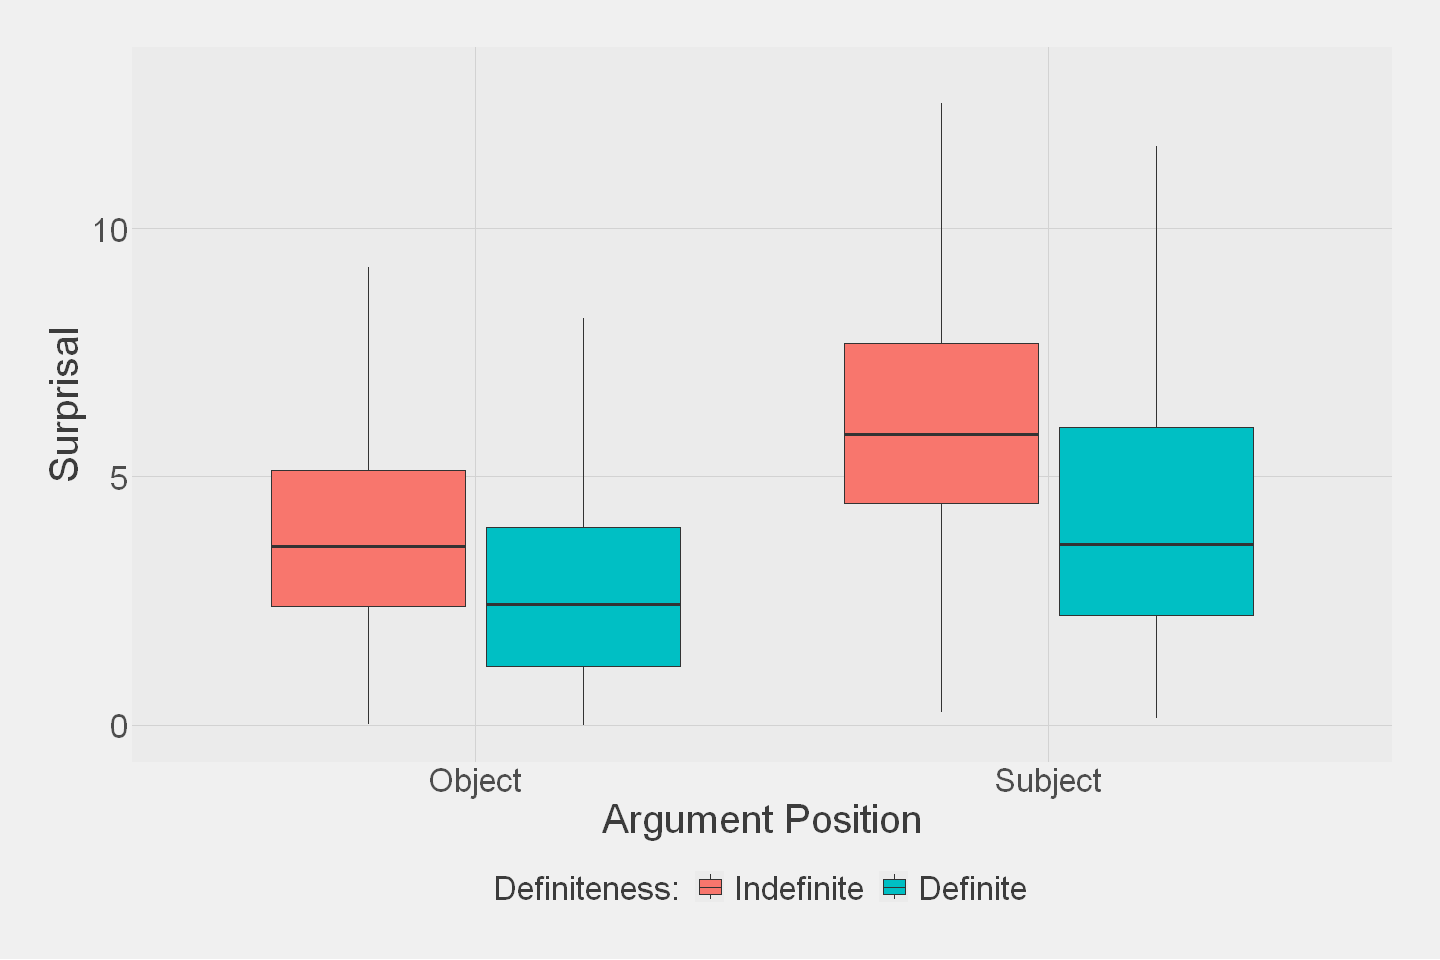

In [132]:
# Plot of argPos, definiteness, and surprisal

ggplot(data = df_nps, aes(y = surprisal, x = argPos, fill = definiteness)) + 
    geom_boxplot(outlier.shape = NA) + 
        coord_cartesian(ylim = c(-.1, 13)) + 
    labs(
        # title = "Argument Position, Definiteness, and Surprisal",
        x = "Argument Position",
        y = "Surprisal",
        fill = "Definiteness:"
    ) + 
    scale_x_discrete(labels = c("sbj" = "Subject", "obj" = "Object")) + 
    scale_fill_discrete(labels = c("indef" = "Indefinite", "def" = "Definite")) + 
    chosen_theme + 
    theme(plot.margin = margin(1, 1, 1, 1, "cm")) + 
    plotFont(2)

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


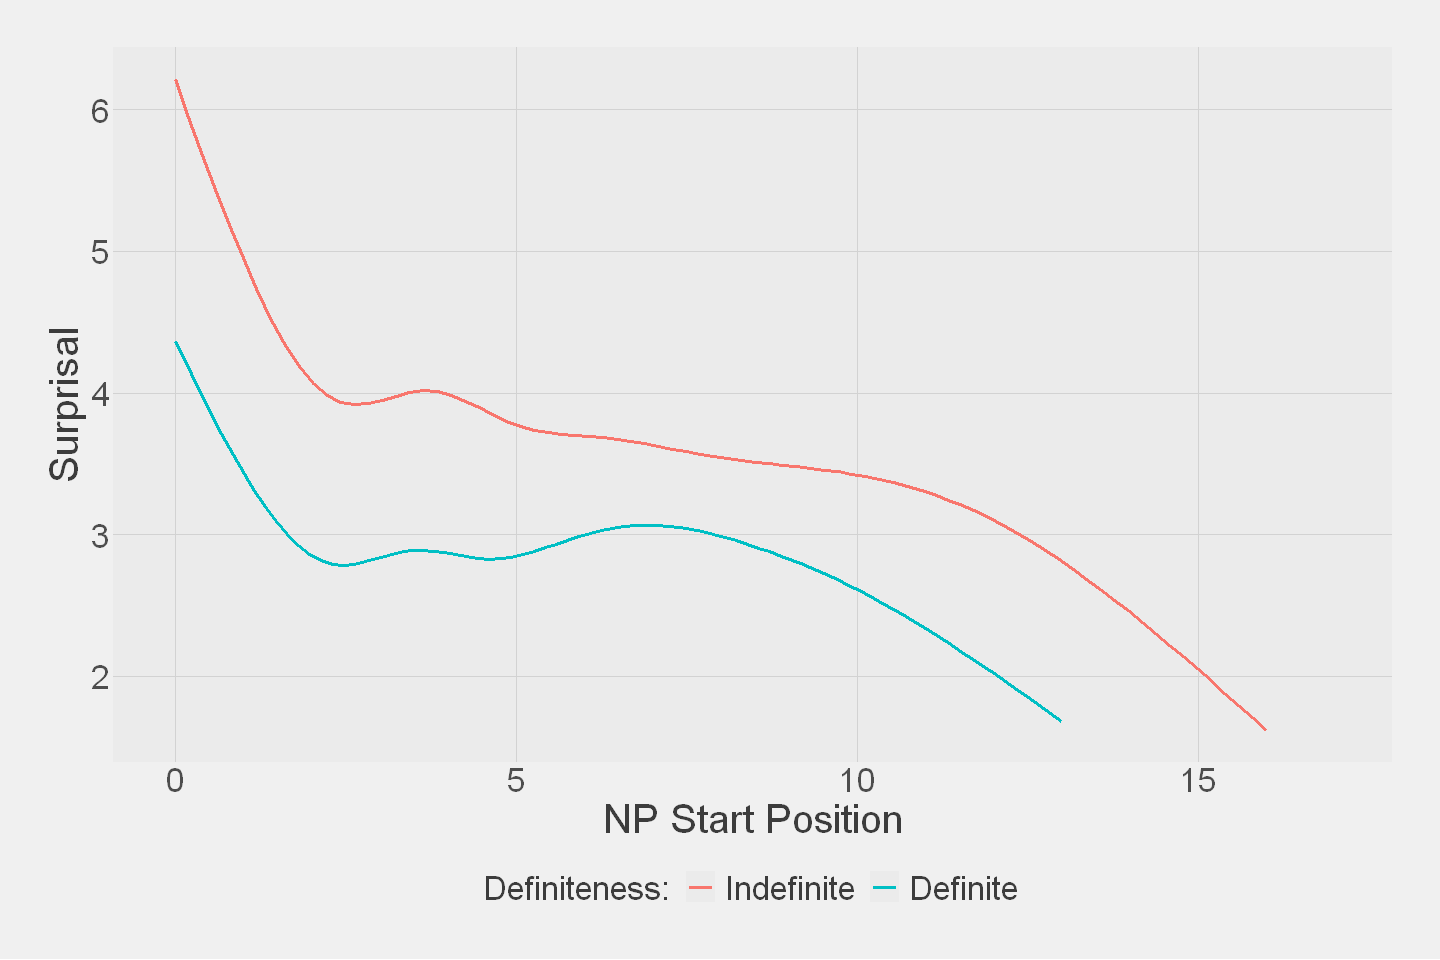

In [63]:
# Plot of effect of NP position effect: 

ggplot(data = df_nps, aes(x = np_start_idx, y = surprisal)) + 
    geom_smooth(se = FALSE, aes(color = definiteness)) + 
    coord_cartesian(x = c(-.05, 17))+ # Range of np_start_idx is 0-16
    labs(
        # title = "Surprisal and NP Start Position",
        x = "NP Start Position",
        y = "Surprisal",
        color = "Definiteness:"
    ) + 
    scale_color_discrete(labels = c("indef" = "Indefinite", "def" = "Definite")) + 
    chosen_theme + 
    theme(plot.margin = margin(1, 1, 1, 1, "cm")) + 
    plotFont(2)
    



In [92]:
df_nps %>%  
    count(np_start_idx)

np_start_idx,n
<dbl>,<int>
0,28401
2,17115
3,7294
4,2536
5,905
6,352
7,129
8,44
9,13


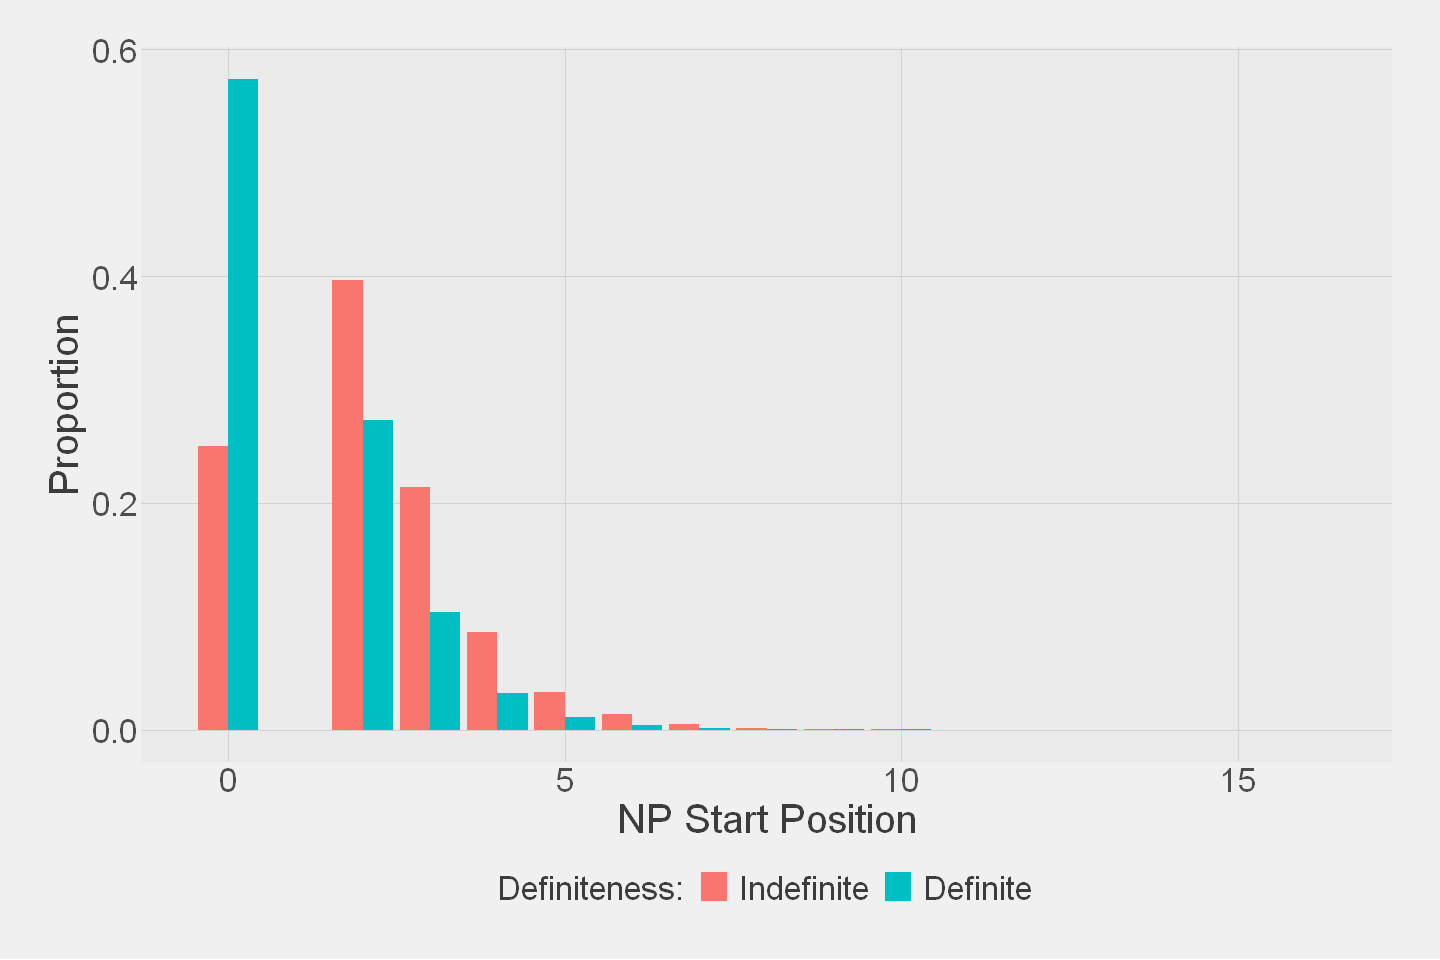

In [ ]:
# Plot of position distribution



ggplot(data = df_nps, aes(x = np_start_idx, fill = definiteness, y = after_stat(prop), group = definiteness)) + 
    geom_bar(position = "dodge") + 
    labs(
        # title = "Proportions of NP Start Positions",
        x = "NP Start Position",
        y = "Proportion",
        fill = "Definiteness:"
    ) + 
    scale_fill_discrete(labels = c("indef" = "Indefinite", "def" = "Definite")) + 
    chosen_theme + 
    theme(plot.margin = margin(1, 1, 1, 1, "cm")) + 
    plotFont(2)


---

# Filtering Code Used:

## Loading from CSV files

``` r
# Read from list of CSVs (can also load from single CSV, parquet, RDS if desired)

df_full <- read_rds("<FILEPATH>")

# Turns into lazy data.table for memory and speed, then clears full df until after cleanup 
# (requires either arrow or data.table and dtplyr): 
df_full_laz <- lazy_dt(df_full) 
    rm(df_full)
    gc()

###

```

## Creating a dataframe of filtered sentences:

```r
df_sent <- df_full_laz %>% 
#
    # Filters to given Criteria
        filter(
        Modality == "written", 
        Sent_Verb_Count == 1,
        Sent_Auxiliary_Count == 0,
        Sent_Subject_Count == 1,
        Sent_Tot_Obj_Count %in% 1,
        Sent_Dir_Object_Count == 1 ,
        Sent_Ind_Object_Count == 0,
        Sent_Sub_Conj_Count == 0,
        Sent_Coord_Conj_Count == 0, 
        Clausal_Complement_Count == 0,
        Sent_Relative_Clause_Count == 0, 
        Sent_Adv_Clause_Count == 0, 
        Sent_Prep_Phrase_Count == 0,
        Sent_Comma_Count == 0,
        !str_detect(Sentence_Text, "\\?"),
        Sent_Transitive == TRUE,
    )  %>%
#
# Removes unneeded columns and collects dt into regular df
    select(Sentence_ID, Sentence_Text, Word_Token_Index, Word_Token, Word_Surprisal, Phrase_Token, Is_NP, Is_Head_Noun, NP_Head_Text, file_name, Filename, NP_Definiteness, NP_Argument, Phrase_Surprisal) %>%
    collect() %>%
#
# Changes names and sets baselines for definiteness, argument position, and surprisal
    mutate(
        definiteness = factor(NP_Definiteness,
        levels = c("indefinite", "definite"),
        labels = c("indef", "def"))
    ) %>% 
    mutate(
        argPos = factor(
            NP_Argument,
            levels = c("dir_object", "subject"),
            labels = c("obj", "sbj")
        )
    ) %>% 
    mutate(surprisal = Phrase_Surprisal) %>%
#
# Tags index of the first token in each NP
    # Finds the token
    arrange(Sentence_ID, Word_Token_Index) %>% 
    group_by(Sentence_ID) %>% 
    mutate(
        prev_is_NP = lag(Is_NP, default = FALSE),
        prev_NP_Head_Text = lag(NP_Head_Text),

        first_token_of_NP = Is_NP & (!prev_is_NP | NP_Head_Text != prev_NP_Head_Text)
    ) %>% 
    ungroup() %>% 
#
    # Grabs index and copies to all rows in NP
    select(-prev_is_NP, -prev_NP_Head_Text) %>% 
    group_by(Sentence_ID, np_id = consecutive_id(Phrase_Token)) %>% 
    mutate(
        np_start_idx = ifelse(
            is.na (Phrase_Token) | Is_NP == FALSE, 
            NA,
            min(Word_Token_Index)
        )
    ) %>% 
    ungroup() %>% 
    select(-np_id) %>% 
#
# Creates per-sentence index that is sequential *within each file* (i.e., each file has 0001, 0002, 0003, ...)
    mutate(
        within_file_id = str_extract(Sentence_ID, "(?<=_)\\d+") %>% 
        as.integer
    ) %>%
#
# Removes sentences in which the subject is not the first word in the sentence, e.g., utterance inversion and non-cannonical sentences
    group_by(Sentence_ID) %>% 
        filter(all(
            (argPos == "sbj" & np_start_idx == 0) |
            (argPos != "sbj") |
            is.na(argPos)
        )) %>%
        ungroup() %>% 
#
# Removes sentences containing NPs that do not have valid argument positions
    group_by(Sentence_ID) %>% 
        filter(all(
            !(Is_NP == TRUE & is.na(argPos))
        )) %>% 
        ungroup() %>% 
#
# Removes duplicate sentences
    arrange(Sentence_ID) %>% 
    group_by(Sentence_Text) %>%
    mutate(first_Sentence_ID = first(Sentence_ID)) %>%
    filter(Sentence_ID == first_Sentence_ID) %>%
    ungroup() %>%
    select(-first_Sentence_ID)


summary(df_sent)
```

## Creating a dataframe of just head nouns

```r
df_nps <- df_sent %>% # Done as a normal dataframe; not large enough to bother converting back to a dt.
    filter(
        Is_NP == TRUE, # Filters to just nouns
        Is_Head_Noun == TRUE, # only head nouns
        definiteness %in% c("def", "indef"), # only valid definiteness values
        argPos %in% c("obj", "sbj"), # only nouns with valid argument positions
        !is.na(surprisal), # only nouns with valid surprisal values
    ) %>% 
    group_by(Sentence_ID) %>% #Double checks that every sentence has exactly one sentence and one object
        filter(n() == 2 & n_distinct(argPos) == 2) %>% 
        ungroup() %>% 
    select(Phrase_Token, surprisal, definiteness, argPos, np_start_idx, Sentence_ID, Sentence_Text)

summary(df_nps)
```
